<a href="https://colab.research.google.com/github/joshbgarfinkel/MachineLearning/blob/main/Copy_of_Princeton_summer_school_comet_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comet challenge
A **machine learning challenge problem** related to astronomical data and equivariant models.

## Authors
- **Soledad Villar** (JHU)
- **David W Hogg** (NYU) (Flatiron)
- **Adrian M Price-Whelan** (Flatiron)

## Challenges:
- Predict the location of Halley's comet at 17:00 EDT on 2022-06-16.
- Predict the date at which the comet will be closest to the Sun in the next 50 years.

## Submit your results:
- Upload your solution as a csv file to https://www.dropbox.com/request/5d5NRnOEulzLFwnYvCLJ (by 17:00 EDT on 2022-06-16)
- Example of a valid submission: https://www.dropbox.com/s/qokukylo9sk4mo7/villar_challenge.csv?dl=0 (make sure your name(s) are in the filename)


In [3]:
!pip install corner

In [126]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import urllib.request
import pickle
import corner

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn


##Load data
The data has the positions and velocities of the Sun, Jupiter and Halley's Comet with respect to the Earth at different times. Units are provided.

In [128]:
Y,names,units = pickle.load(urllib.request.urlopen("https://github.com/solevillar/Comet_challenge/raw/main/comet.pkl"))

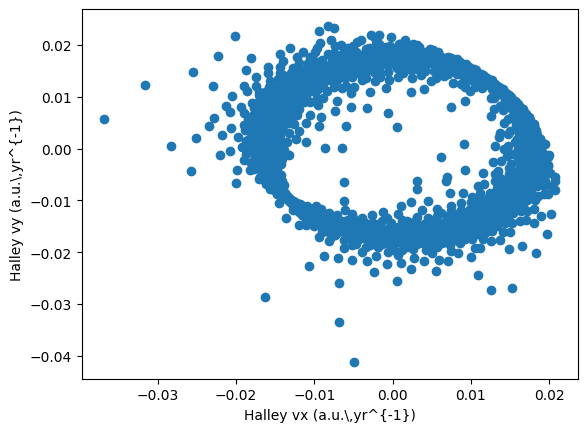

In [129]:
# Sanity-check the data.
for i in [16,]:
    j = i + 1
    plt.scatter(Y[:, i], Y[:, j])
    plt.xlabel(names[i] + " (" + units[i] + ")")
    plt.ylabel(names[j] + " (" + units[i] + ")")

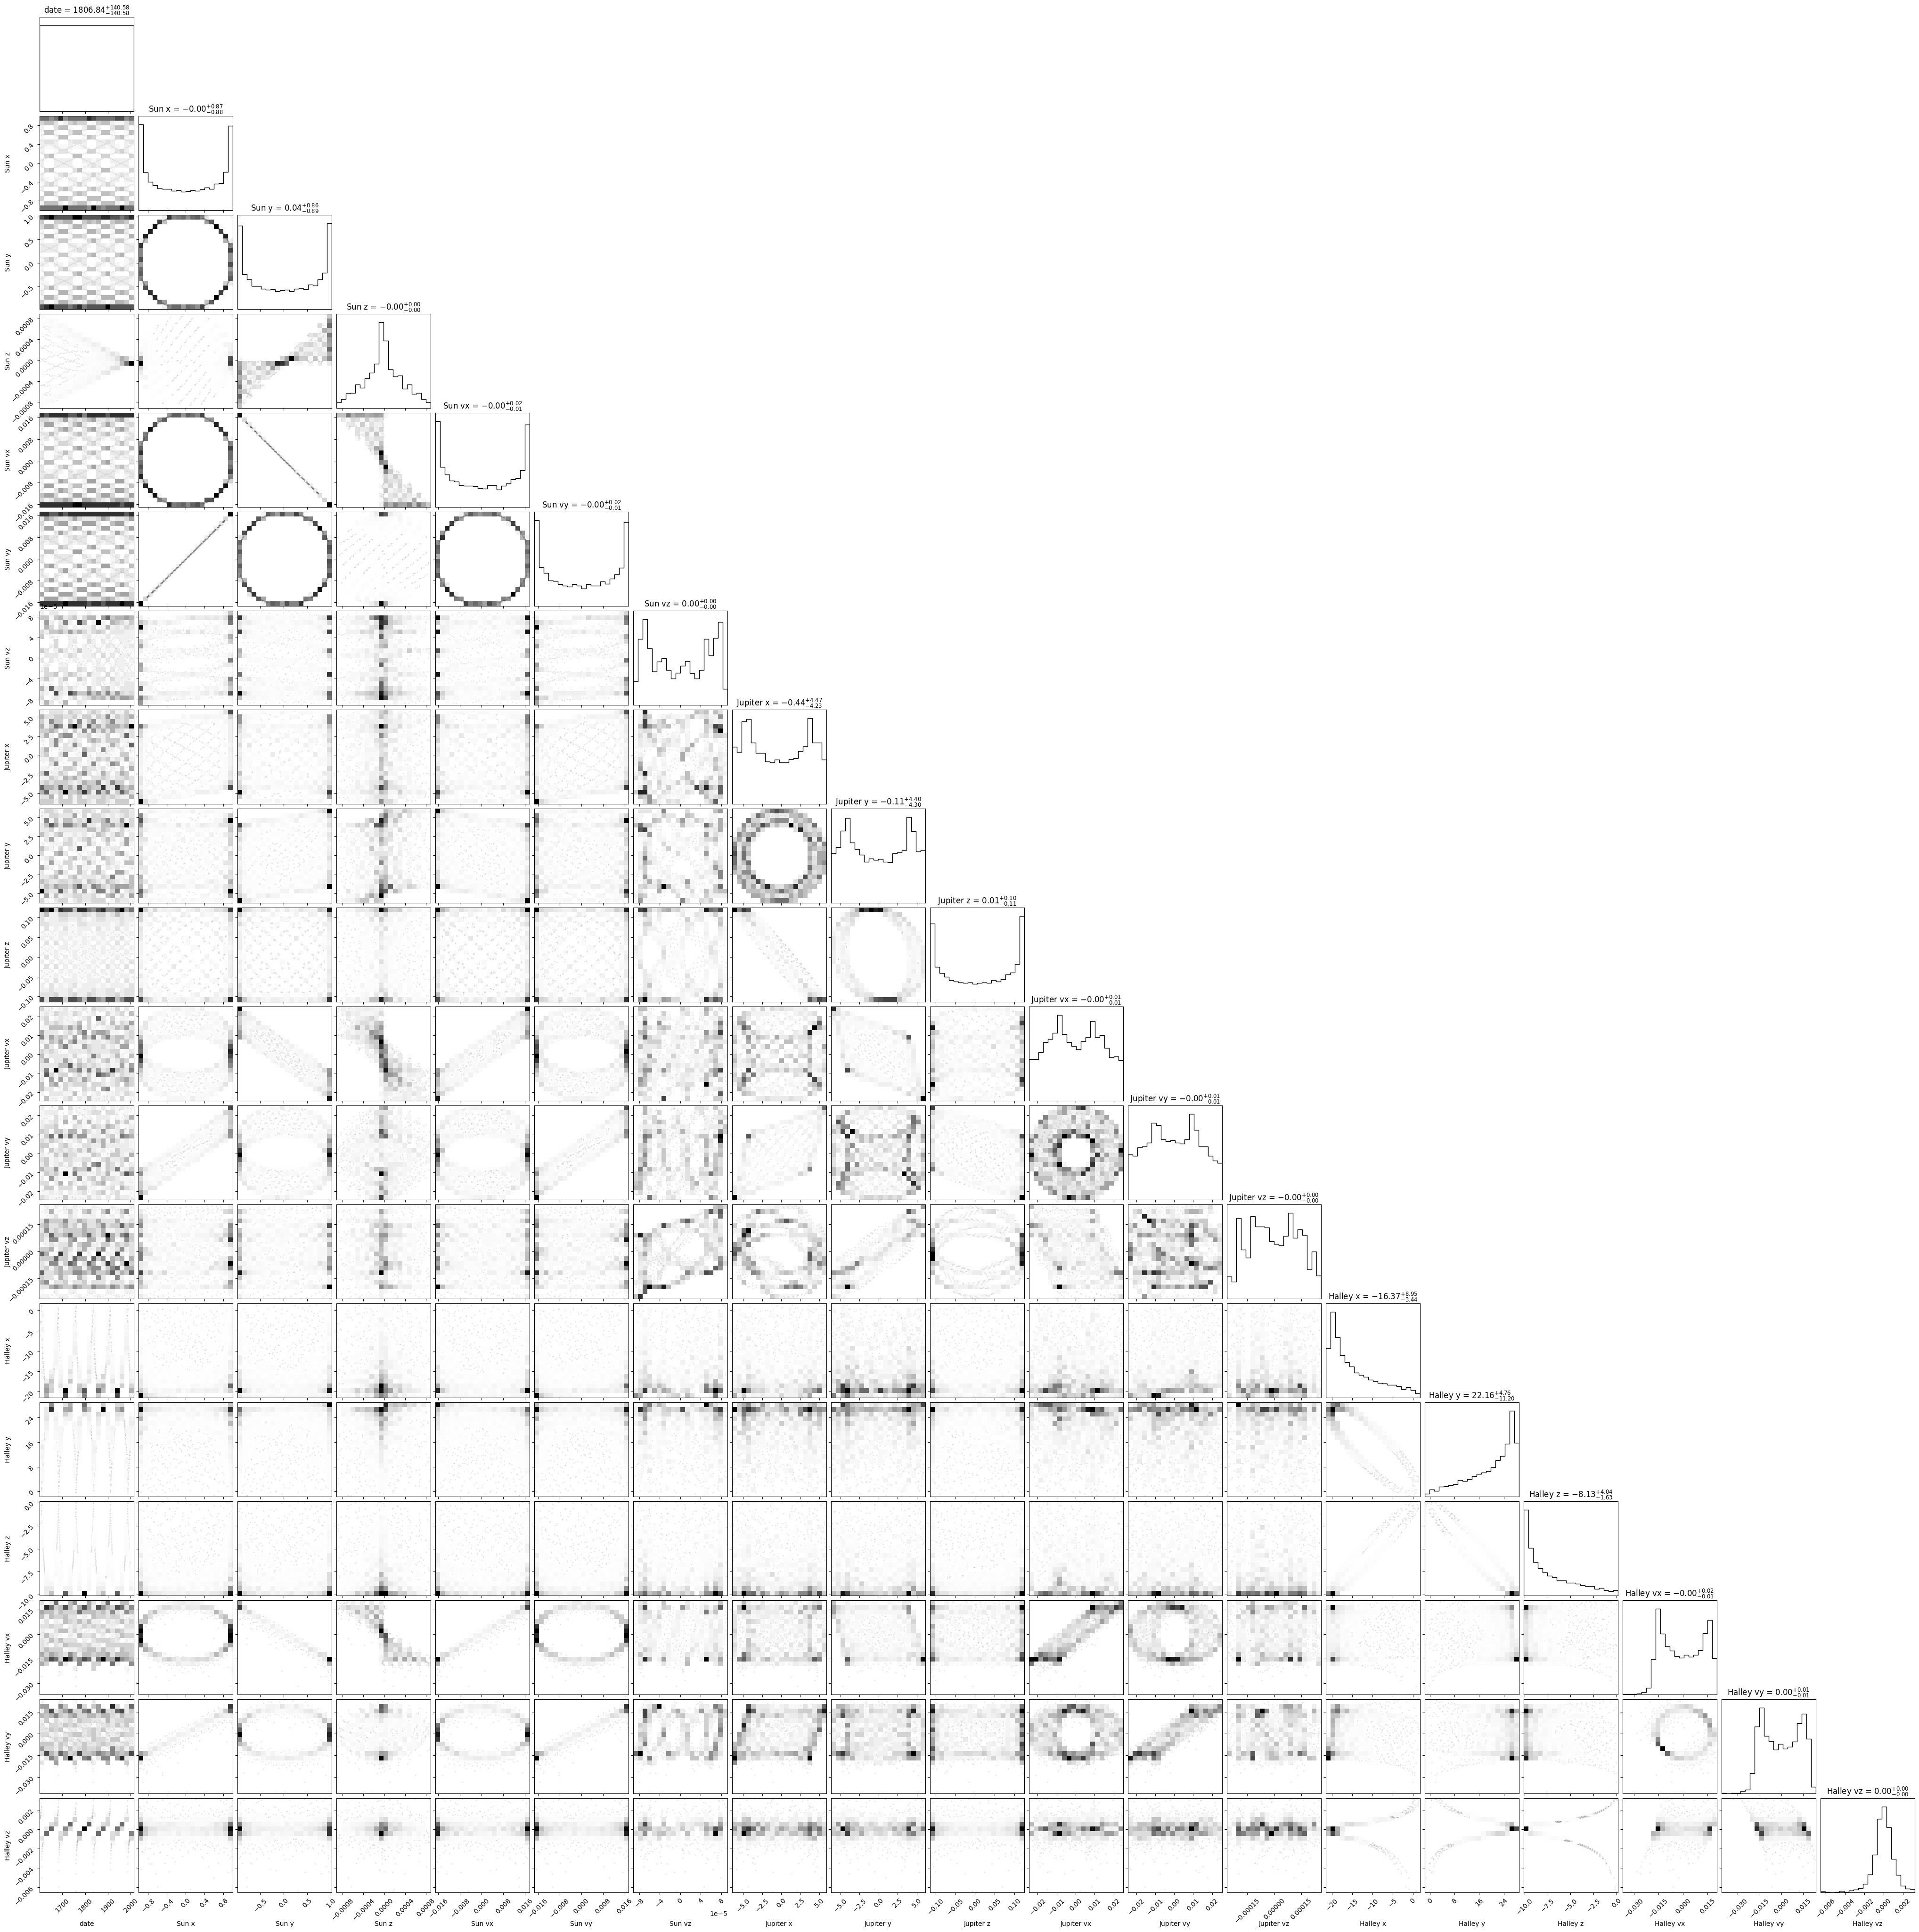

In [130]:
# Make beautiful plots
# we can observe the data is very structured
figure = corner.corner(Y, labels=names,
                       show_titles=True, plot_contours=False)

In [131]:
print(Y)
print(names)
print(units)

[[ 1.60010000e+03  7.86843237e-01 -5.96217497e-01 ...  1.29224975e-02
   1.08815575e-02  1.04289894e-03]
 [ 1.60041831e+03  2.28515420e-01  9.89179409e-01 ... -1.41712166e-02
   6.08464022e-04  1.20973539e-03]
 [ 1.60073662e+03 -9.88643327e-01 -1.53600110e-01 ...  5.05912844e-03
  -2.00691260e-02  1.08228837e-03]
 ...
 [ 2.01294792e+03 -1.65073966e-01 -9.70614028e-01 ...  1.68787650e-02
  -1.79480021e-03 -2.05074173e-04]
 [ 2.01326623e+03  9.54445311e-01  3.02121804e-01 ... -4.92317412e-03
   1.76388205e-02 -2.68006997e-04]
 [ 2.01358454e+03 -6.43999792e-01  7.84420493e-01 ... -1.32320410e-02
  -9.99721631e-03 -1.32930779e-04]]
['date', 'Sun x', 'Sun y', 'Sun z', 'Sun vx', 'Sun vy', 'Sun vz', 'Jupiter x', 'Jupiter y', 'Jupiter z', 'Jupiter vx', 'Jupiter vy', 'Jupiter vz', 'Halley x', 'Halley y', 'Halley z', 'Halley vx', 'Halley vy', 'Halley vz']
['yr', 'a.u.', 'a.u.', 'a.u.', 'a.u.\\,yr^{-1}', 'a.u.\\,yr^{-1}', 'a.u.\\,yr^{-1}', 'a.u.', 'a.u.', 'a.u.', 'a.u.\\,yr^{-1}', 'a.u.\\,yr^{-1}

In [132]:
dates = Y[:, 0]  # Years
features = Y[:, 1:13]  # Sun and Jupiter positions and velocities
halley_positions = Y[:, 13:16]  # Halley's comet positions (x, y, z)
halley_velocities = Y[:, 16:]  # Halley's comet velocities (vx, vy, vz)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, halley_positions, test_size=0.2, random_state=42)

In [133]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

date_query = 2022.5 + (31 + 30 + 16) / 365.242199
features_query = Y[abs(dates - date_query).argmin(), 1:13]
features_query_scaled = scaler.transform(features_query.reshape(1, -1))

predicted_position = model.predict(features_query_scaled)

print("Predicted position of Halley's comet on 2022-06-16 17:00 EDT:", predicted_position)

Predicted position of Halley's comet on 2022-06-16 17:00 EDT: [[-18.66367599  22.66589102  -8.60174844]]


In [134]:
future_dates = np.linspace(2023, 2073, 500)
future_features = np.array([Y[abs(dates - year).argmin(), 1:13] for year in future_dates])
future_features_scaled = scaler.transform(future_features)
future_positions = model.predict(future_features_scaled)

sun_positions = future_features[:, :3]
distances_to_sun = np.linalg.norm(future_positions - sun_positions, axis=1)
closest_date = future_dates[distances_to_sun.argmin()]

print("Date of closest approach to the Sun in the next 50 years:", closest_date)
print(Y.shape)

Date of closest approach to the Sun in the next 50 years: 2023.0
(1300, 19)


In [149]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

dates = Y[:, 0]  # Extract years
features = Y[:, 1:13]  # Sun and Jupiter positions and velocities
positions = Y[:, 13:16]  # positions (x, y, z)

scaler_features = StandardScaler()
scaler_positions = StandardScaler()

features_scaled = scaler_features.fit_transform(features)
positions_scaled = scaler_positions.fit_transform(positions)


def seq(features, positions, seq_length=5):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(positions[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = seq(features_scaled, positions_scaled, seq_length)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(y_train.shape)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


class TrajectoryLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(TrajectoryLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out


input_dim = features_scaled.shape[1]
hidden_dim = 64
output_dim = positions_scaled.shape[1]
num_layers = 2
learning_rate = 0.005
epochs = 500

model = TrajectoryLSTM(input_dim, hidden_dim, output_dim, num_layers)
mse = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = mse(output, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")


model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = mse(predictions, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")


predicted_positions = scaler_positions.inverse_transform(predictions.numpy())
actual_positions = scaler_positions.inverse_transform(y_test.numpy())

print("Predicted positions (scaled back):", predicted_positions[:5])
print("Actual positions (scaled back):", actual_positions[:5])

(1032, 3)
Epoch 10, Loss: 0.9868
Epoch 20, Loss: 0.9749
Epoch 30, Loss: 0.8821
Epoch 40, Loss: 0.5289
Epoch 50, Loss: 0.2862
Epoch 60, Loss: 0.1981
Epoch 70, Loss: 0.1409
Epoch 80, Loss: 0.1039
Epoch 90, Loss: 0.0753
Epoch 100, Loss: 0.0717
Epoch 110, Loss: 0.0630
Epoch 120, Loss: 0.0412
Epoch 130, Loss: 0.0269
Epoch 140, Loss: 0.0194
Epoch 150, Loss: 0.0147
Epoch 160, Loss: 0.0120
Epoch 170, Loss: 0.0102
Epoch 180, Loss: 0.0093
Epoch 190, Loss: 0.0165
Epoch 200, Loss: 0.0086
Epoch 210, Loss: 0.0070
Epoch 220, Loss: 0.0060
Epoch 230, Loss: 0.0054
Epoch 240, Loss: 0.0049
Epoch 250, Loss: 0.0045
Epoch 260, Loss: 0.0042
Epoch 270, Loss: 0.0039
Epoch 280, Loss: 0.0037
Epoch 290, Loss: 0.0135
Epoch 300, Loss: 0.0045
Epoch 310, Loss: 0.0041
Epoch 320, Loss: 0.0033
Epoch 330, Loss: 0.0029
Epoch 340, Loss: 0.0027
Epoch 350, Loss: 0.0026
Epoch 360, Loss: 0.0025
Epoch 370, Loss: 0.0023
Epoch 380, Loss: 0.0022
Epoch 390, Loss: 0.0022
Epoch 400, Loss: 0.0021
Epoch 410, Loss: 0.0035
Epoch 420, Loss

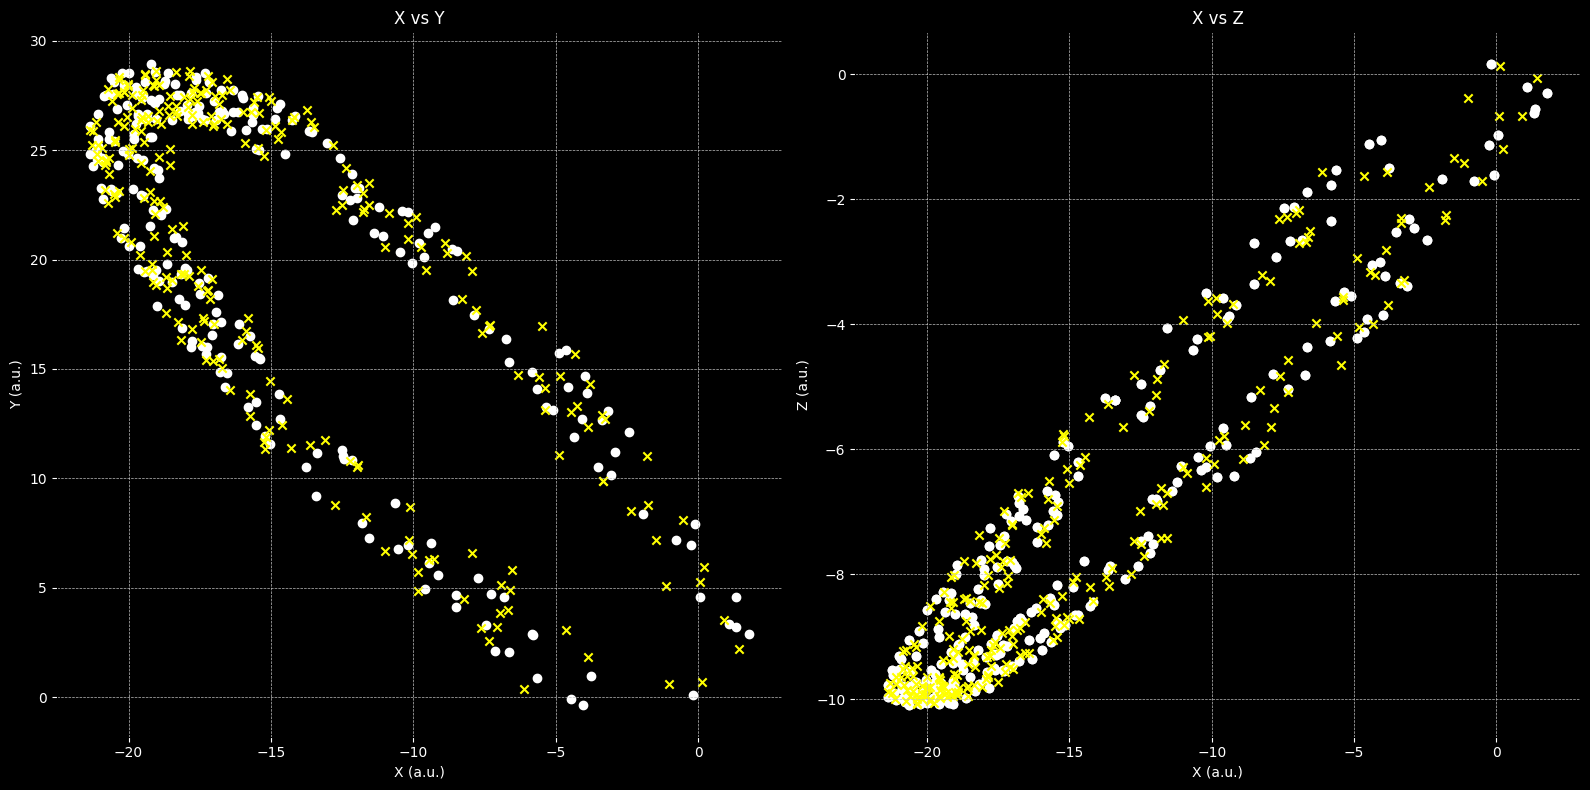

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.patch.set_facecolor('black')


ax1 = axes[0]

ax1.set_facecolor('black')
ax1.scatter(actual_positions[:, 0], actual_positions[:, 1], label='Actual Path', color='white')
ax1.scatter(predicted_positions[:, 0], predicted_positions[:, 1], label='Predicted Path', color='yellow', marker='x')

ax1.set_xlabel('X (a.u.)', color='white')
ax1.set_ylabel('Y (a.u.)', color='white')
ax1.set_title('X vs Y', color='white')

ax1.grid(color='silver', linestyle='--', linewidth=0.5)
ax1.tick_params(colors='white')


ax2 = axes[1]

ax2.set_facecolor('black')
ax2.scatter(actual_positions[:, 0], actual_positions[:, 2], label='Actual Path', color='white')
ax2.scatter(actual_positions[:, 0], actual_positions[:, 2], label='Actual Path', color='white')
ax2.scatter(predicted_positions[:, 0], predicted_positions[:, 2], label='Predicted Path', color='yellow', marker='x')

ax2.set_xlabel('X (a.u.)', color='white')
ax2.set_ylabel('Z (a.u.)', color='white')
ax2.set_title('X vs Z', color='white')

ax2.grid(color='silver', linestyle='--', linewidth=0.5)
ax2.tick_params(colors='white')


plt.tight_layout()
plt.show()


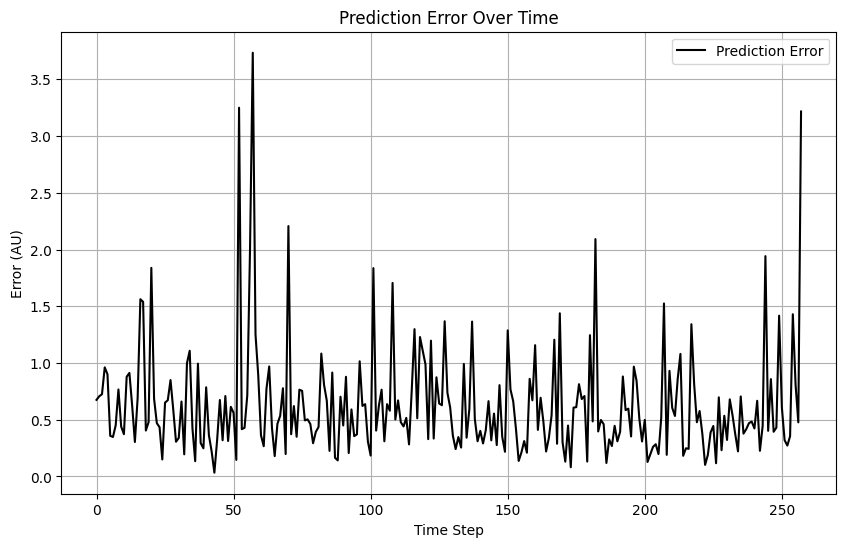

In [152]:
errors = np.linalg.norm(actual_positions - predicted_positions, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(range(len(errors)), errors, label='Prediction Error', color='k')
plt.title("Prediction Error Over Time")
plt.xlabel("Time Step")
plt.ylabel("Error (AU)")
plt.legend()
plt.grid(True)
plt.show()

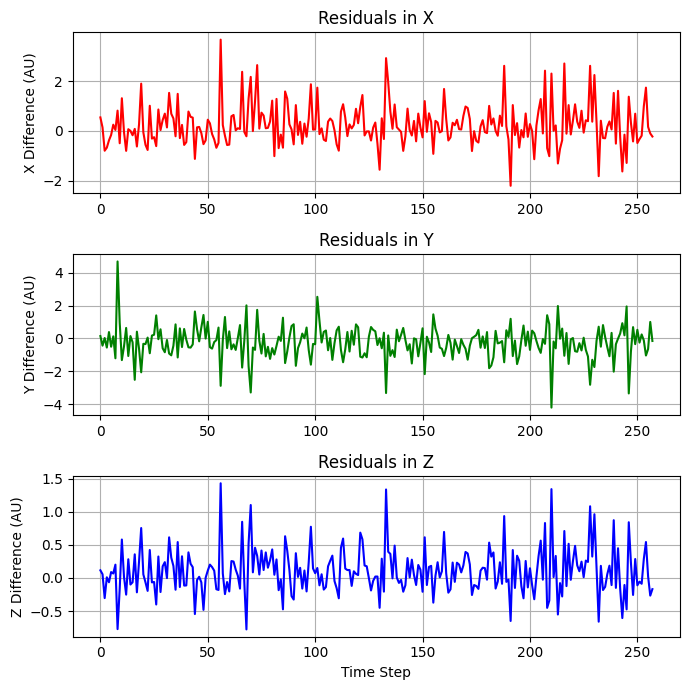

In [52]:
residuals = actual_positions - predicted_positions

fig, axes = plt.subplots(3, 1, figsize=(7, 7))

axes[0].plot(residuals[:, 0], label='Residuals in X', color='red')
axes[0].set_title("Residuals in X")
axes[0].set_ylabel("X Difference (AU)")
axes[0].grid(True)

axes[1].plot(residuals[:, 1], label='Residuals in Y', color='green')
axes[1].set_title("Residuals in Y")
axes[1].set_ylabel("Y Difference (AU)")
axes[1].grid(True)

axes[2].plot(residuals[:, 2], label='Residuals in Z', color='blue')
axes[2].set_title("Residuals in Z")
axes[2].set_ylabel("Z Difference (AU)")
axes[2].set_xlabel("Time Step")
axes[2].grid(True)

plt.tight_layout()
plt.show()

Center: [-14.39548586  19.7526953   -7.21970039], R_major: 8.592400999561884, R_minor: 18.404184688031183


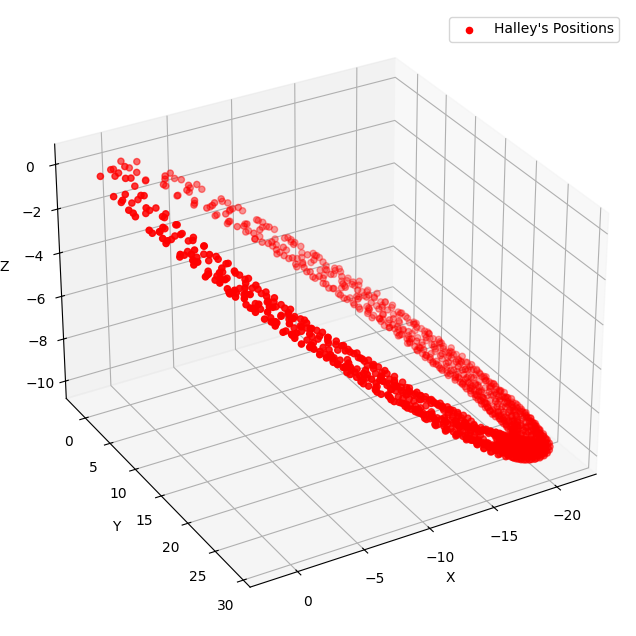

In [90]:
# Halley's comet positions (replace with your actual dataset)
halley_positions = np.array(Y[:, 13:16])  # Extract positions (x, y, z)

# Compute the center of the data
center = np.mean(halley_positions, axis=0)

# Transform data relative to the center
data_centered = halley_positions - center

# Compute the major radius (average distance in x-y plane)
distances_xy = np.sqrt(data_centered[:, 0]**2 + data_centered[:, 1]**2)
R_major = np.mean(distances_xy)

# Compute the minor radius (max deviation in z after accounting for R_major)
deviation_z = np.sqrt((distances_xy - R_major)**2 + data_centered[:, 2]**2)
R_minor = np.max(deviation_z)

print(f"Center: {center}, R_major: {R_major}, R_minor: {R_minor}")

# Visualization
theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 50)
theta, phi = np.meshgrid(theta, phi)

# Parametric equations for the torus
x = (R_major + R_minor * np.cos(phi)) * np.cos(theta) + center[0]
y = (R_major + R_minor * np.cos(phi)) * np.sin(theta) + center[1]
z = R_minor * np.sin(phi) + center[2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the torus
#ax.plot_surface(x, y, z, color='lightblue', alpha=0.5, edgecolor='gray')

# Plot the data points
ax.scatter(halley_positions[:, 0], halley_positions[:, 1], halley_positions[:, 2], color='red', label="Halley's Positions")
ax.view_init(elev=30, azim=60)
# Customize the plot
#ax.set_title("Torus Shrink-Wrapping Halley's Comet Data")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()